## prepare

In [2]:
cd /Users/schlecker/WINE/TIC237913194

/Users/schlecker/WINE/TIC237913194


In [3]:
%matplotlib inline
# %matplotlib notebook

# set default figure size
figsize = [4.3, 3.2]

some variables already defined in TIC237913194.py

In [4]:
import copy
import starry
import exoplanet
import healpy as hp

import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as c

from popsyntools import plots, plotstyle, stats, utils, output
from popsyntools.plotstyle import set_size

import aux
import plots
from TIC237913194 import *
from utils_planets import *

%load_ext autoreload
%autoreload 2

# show more columns in pandas data frames
pd.set_option('display.max_columns', 500)

writing to out/39_tess+chat+feros+GP/posterior_table.tex.
% These params were not able to be latexifyed
% ['unnamed' 'loglike']


In [5]:
# Stellar parameters for TIC237913194
m_s = 1.026
m_s_e = 0.057
r_s = 1.088
r_s_e = 0.012
teff_star=[5788,80]
vsini_star=2.18

In [6]:
datafolder = 'data/'
plotDir = 'plots/'
# out_folder = 'out/21_tess+chat+feros+CORALIE+noGP'
# out_folder = 'out/22_tess+chat+feros+CORALIE+GP'
# out_folder = 'out/23_tess+chat+feros+noGP'
# out_folder = 'out/25_tess+chat+feros+noGP'
# out_folder = 'out/26_tess+chat+feros+noGP'
# out_folder = 'out/27_tess+chat+feros+GP'
# out_folder = 'out/31_feros_noPlanet'
# out_folder = 'out/33d_feros_uniformPprior'
out_folder = 'out/39_tess+chat+feros+GP/'


# Read results from the fits 


In [7]:
priors, params = get_priors(GP=True)
times_lc, fluxes, fluxes_error, gp_times_lc = read_photometry(datafolder,
                                                plotPhot=False, outlierIndices=outlierIndices)
times_rv, rvs, rvs_error = read_rv(datafolder)

dataset = juliet.load(
    priors=priors, t_lc=times_lc, y_lc=fluxes, yerr_lc=fluxes_error,
    t_rv=times_rv, y_rv=rvs, yerr_rv=rvs_error,
    GP_regressors_lc=gp_times_lc,
    out_folder=out_folder, verbose=True)
# results = dataset.fit(use_dynesty=True, dynamic=True) # has to be ~same call as during fit

results = pickle.load(open(out_folder + '/results.pkl', 'rb'))

	 Transit fit detected for instrument  TESSERACT+TESS
	 Transit fit detected for instrument  CHAT+i
	 >> sqrt(e)cosomega, sqrt(e)sinomega parametrization detected for lc planet p1
	 >> sqrt(e)cosomega, sqrt(e)sinomega parametrization detected for rv planet p1


## plot posteriors

In [8]:
if 'r1_p1' in results.posteriors['posterior_samples']:
    r1, r2 = results.posteriors['posterior_samples']['r1_p1'], \
         results.posteriors['posterior_samples']['r2_p1']
    b, p = juliet.utils.reverse_bp(r1, r2, pl, pu)
else:
    b, p = None, None

if 'q1_TESSERACT+TESS' in results.posteriors['posterior_samples']:
    q1_tess, q2_tess = results.posteriors['posterior_samples']['q1_TESSERACT+TESS'], \
                       results.posteriors['posterior_samples']['q2_TESSERACT+TESS']
    u1_tess, u2_tess = juliet.utils.reverse_ld_coeffs('quadratic', q1_tess, q2_tess)
else:
    u1_tess = None
    u2_tess = None
if 'q1_CHAT+i' in results.posteriors['posterior_samples']:
    q1_chat = results.posteriors['posterior_samples']['q1_CHAT+i']
    u1_chat, u1_chat = juliet.utils.reverse_ld_coeffs('linear', q1_chat, q1_chat)
else:
    u1_chat = None
    u2_chat = None

if 'secosomega_p1' in results.posteriors['posterior_samples']:
    # back-transfrom ecc, omega parametrization
    secosomega = results.posteriors['posterior_samples']['secosomega_p1']
    sesinomega = results.posteriors['posterior_samples']['sesinomega_p1']
    ecc = secosomega ** 2 + sesinomega ** 2
    omega = np.arccos(secosomega / np.sqrt(ecc)) * 180/np.pi
else:
    ecc = None
    omega = None


# extract posteriors, excluding fixed parameters
try:
    posteriorSamples = results.posteriors['posterior_samples'].copy()
except AttributeError:
    posteriorSamples = results[0].posteriors['posterior_samples'].copy()

posteriors = []
for name in results.data.priors:
    if (name not in ['r1_p1','r2_p1','q1_TESSERACT+TESS','q2_TESSERACT+TESS',
                     'sigma_w_TESSERACT+TESS',
            'q1_CHAT+i', 'secosomega_p1', 'sesinomega_p1']) & \
            (results.data.priors[name]['distribution'] != 'fixed'):
        # consider all non-fixed params, except special parametrizations
        if results.data.priors[name]['distribution'] == 'loguniform':
            # plot log. distributed params in log
            posteriors.append(('log '+name, np.log10(posteriorSamples[name])))
        else:
            posteriors.append((name,posteriorSamples[name]))

    if (name in ['sigma_w_TESSERACT+TESS']) & \
            (results.data.priors[name]['distribution'] != 'fixed'):
        # dirty hack for some params that shouldn't be plotted in log
        posteriors.append((name, posteriorSamples[name]))

# include special parametrizations
if ecc is not None:
    posteriors.append(('ecc', ecc))
    posteriors.append(('omega', omega))
if b is not None:
    posteriors.append(('b', b))
    posteriors.append(('p', p))
if u1_tess is not None:
    posteriors.append(('u1_TESSERACT+TESS', u1_tess))
    posteriors.append(('u2_TESSERACT+TESS', u2_tess))
if u1_chat is not None:
    posteriors.append(('u1_CHAT+i', u1_chat))
    
# print(posteriors)
posterior_names = ['P_p1', 't0_p1', 'K_p1', 'p_p1', 'ecc']


posterior_data = []
# for label in posterior_names:
for label, posterior_samples in zip([p[0] for p in posteriors], posteriors):#[p[1] for p in posteriors]):
    if label in posterior_names:
        posterior_data.append(posterior_samples)
        
        
print([p[0] for p in posterior_data])

['P_p1', 't0_p1', 'p_p1', 'K_p1', 'ecc']


In [371]:
[p[0] for p in posteriors]

NameError: name 'posteriors' is not defined

In [306]:
pd.DataFrame(data = [[p[1] for p in posteriors]], columns=[p[0] for p in posteriors])

,P_p1,t0_p1,p_p1,b_p1,rho,sigma_w_TESSERACT+TESS,mflux_TESSERACT+TESS,log GP_sigma_TESSERACT+TESS,log GP_timescale_TESSERACT+TESS,log sigma_w_CHAT+i,mflux_CHAT+i,K_p1,mu_FEROS,log sigma_w_FEROS,ecc,omega,u1_TESSERACT+TESS,u2_TESSERACT+TESS,u1_CHAT+i
0,"[15.168948177793306, 15.168833455500241, 15.16...","[2458319.1487976154, 2458319.1512605296, 24583...","[0.0977452684563333, 0.1032632762975963, 0.111...","[0.9001167020516382, 0.8835375832081309, 0.895...","[970.775500986908, 1138.0119772882485, 1263.04...","[156.3158649882813, 105.76828908707554, 5.7813...","[-0.019832455367222324, 0.0029207791755611633,...","[-3.869358337512306, -4.882916780713636, -5.91...","[-2.372833955033871, -1.352309028676965, -0.32...","[3.20018276976007, 3.1859600485388846, 3.24603...","[0.0012401165272300624, 0.0007593237220346813,...","[177.31463670025033, 180.19230312095297, 182.7...","[15.285015957196833, 21.76912190147155, 20.034...","[1.3034995737584063, 1.216294408015799, 0.9870...","[0.5720300456054603, 0.5483150347016421, 0.565...","[29.23584962949692, 24.732274270885718, 25.597...","[0.6409306626121581, 0.32266402055268123, 1.01...","[-0.03363469523011028, 0.4947019900724207, -0....","[0.156323037242259, 0.4957904929050665, 0.7346..."


In [12]:
pl = 0.
pu = 0.5
# fig = plots.plot_cornerPlot(results, pl=results.pl, pu=results.pu,
#                                 quantiles=[0.16, 0.5, 0.84], show_titles=True,
#                                 title_kwargs={"fontsize": 16}, title_fmt='.2f',
#                                 rasterized=True,
#                                 label_kwargs={"fontsize": 16 })
# fig.savefig(out_folder + '/cornerPosteriors.pdf', rasterized=True)

...and a smaller corner plot including only major parameters

In [15]:
params = ['P_p1', 't0_p1', 'K_p1', 'p_p1']
sampleRanges = [1. for i in params]
sampleRanges[2] = (0.075,0.175)    # order is not the one in the list 'params'

fig= plots.plot_cornerPlot(results, posterior_names=params, pl=results.pl, pu=results.pu,
                                quantiles=[0.16, 0.5, 0.84], show_titles=True, reverse=False,
                                title_kwargs={"fontsize": 16}, title_fmt='.2f',
                                rasterized=True,
                                label_kwargs={"fontsize": 16 },
                                range=sampleRanges)
# fig.savefig(out_folder + '/cornerMajorParams.pdf', rasterized=True)

In [ ]:
fig

and a more complicated version with an additional flipped corner plot (one for fitting params, one for physical params)

NameError: name 'sampleRanges' is not defined

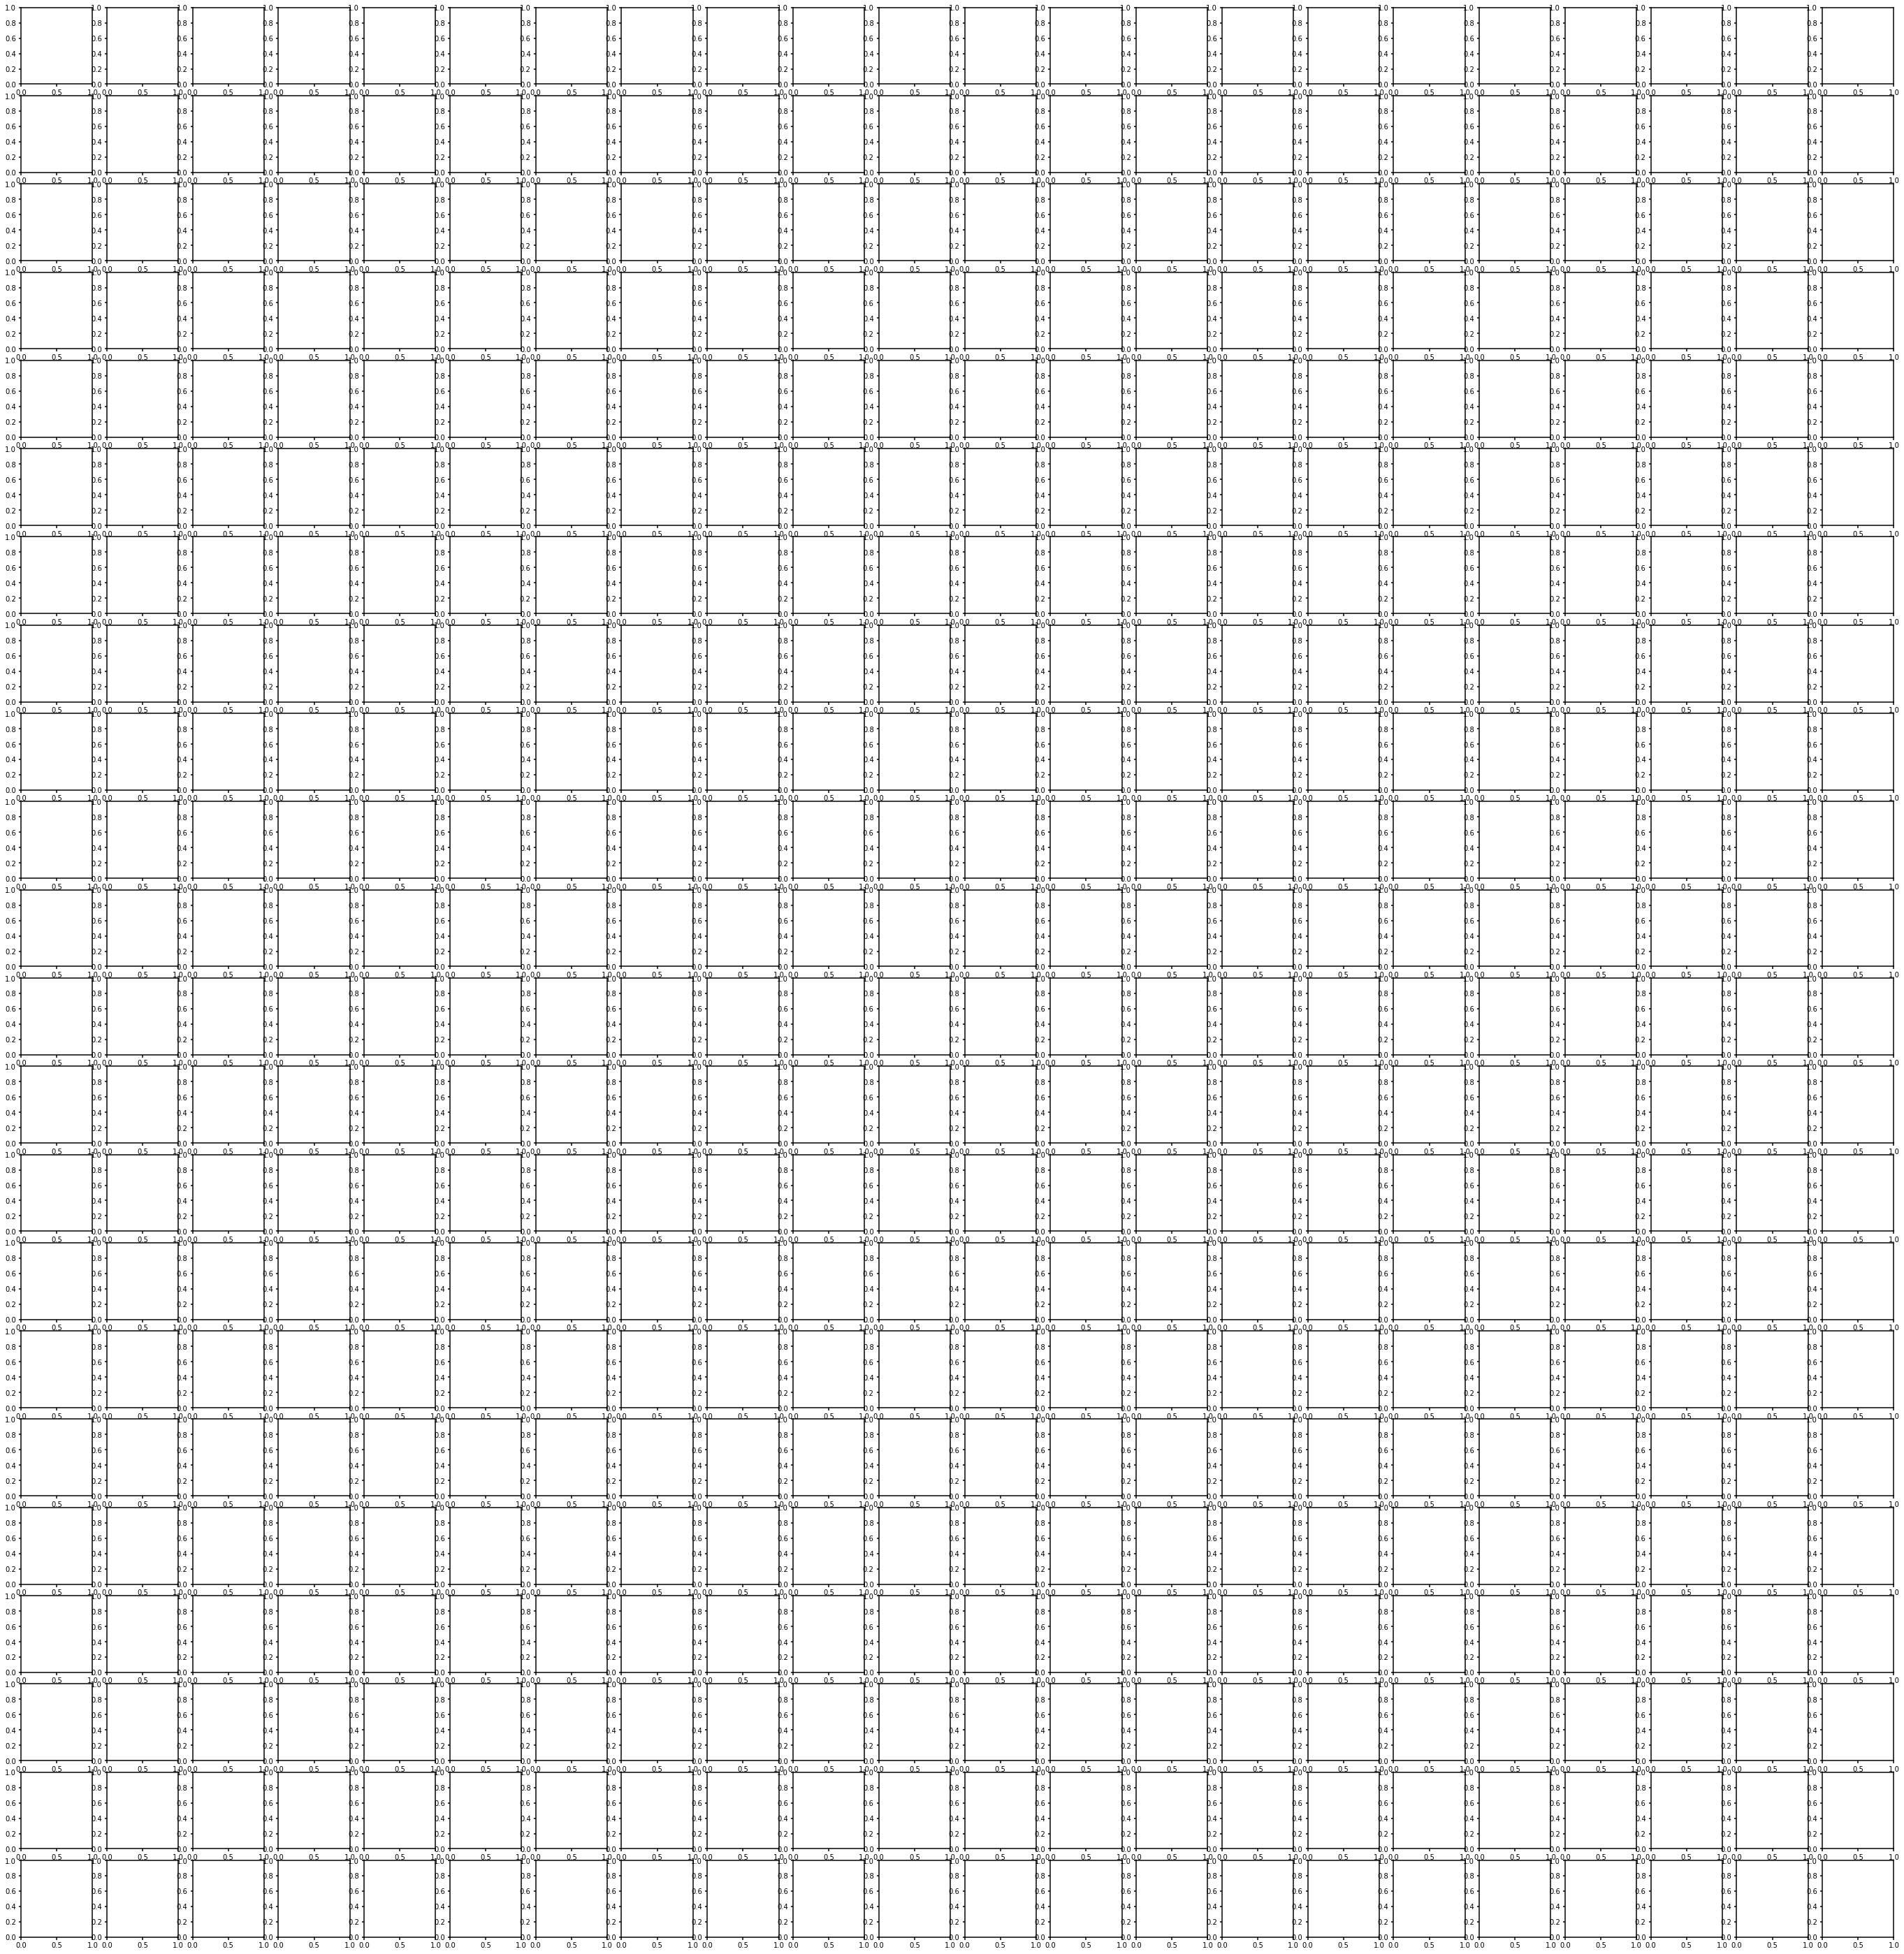

In [259]:
ndim = len(params)
params2 = ['ecc', 'b_p1', 'radius_rj_p1']
ndim2 = len(params2)



# Some magic numbers for pretty axis layout (as in corner.corner)
K = ndim
factor = 2.0           # size of one side of one panel
# if reverse:
#     lbdim = 0.2 * factor   # size of left/bottom margin
#     trdim = 0.5 * factor   # size of top/right margin
# else:
lbdim = 0.5 * factor   # size of left/bottom margin
trdim = 0.2 * factor   # size of top/right margin
whspace = 0.05         # w/hspace size
plotdim = factor * K + factor * (K - 1.) * whspace
dim = lbdim + plotdim + trdim

# Create a new figure
figAll, caxes = plt.subplots(ndim+1,ndim+1, figsize=(dim, dim))
# [ax.axis("off") for ax in caxes.flatten()]


# lower left corner
idx=[]
for i in range(ndim):
    for j in range(ndim):
        if j <= i:
            idx.append((i,j))
loweraxes = [caxes[tupel[0], tupel[1]] for tupel in idx]

figAll = plots.plot_cornerPlot(results, posterior_names=params, pl=results.pl, pu=results.pu,
                                fig=figAll, axes=caxes[-ndim:,0:ndim],
                                quantiles=[0.16, 0.5, 0.84], show_titles=True, reverse=False,
                                title_kwargs={"fontsize": 16}, title_fmt='.2f',
                                rasterized=True,
                                label_kwargs={"fontsize": 16},
                                range=sampleRanges)



# upper right corner
figAll= plots.plot_cornerPlot(results, posterior_names=params2, pl=results.pl, pu=results.pu,
                                fig=figAll, axes=caxes[0:ndim2,-ndim2:],
                                quantiles=[0.16, 0.5, 0.84], show_titles=True, reverse=True,
                                title_kwargs={"fontsize": 16}, title_fmt='.2f',
                                rasterized=True,
                                label_kwargs={"fontsize": .3, 'alpha':0.}
                             )
#                                 range=sampleRanges)

# remove spines etc. from unused axes
for ax in caxes[0,:-ndim2]:
    ax.axis('off')
for ax in caxes[ndim2:,-1]:
    ax.axis('off')

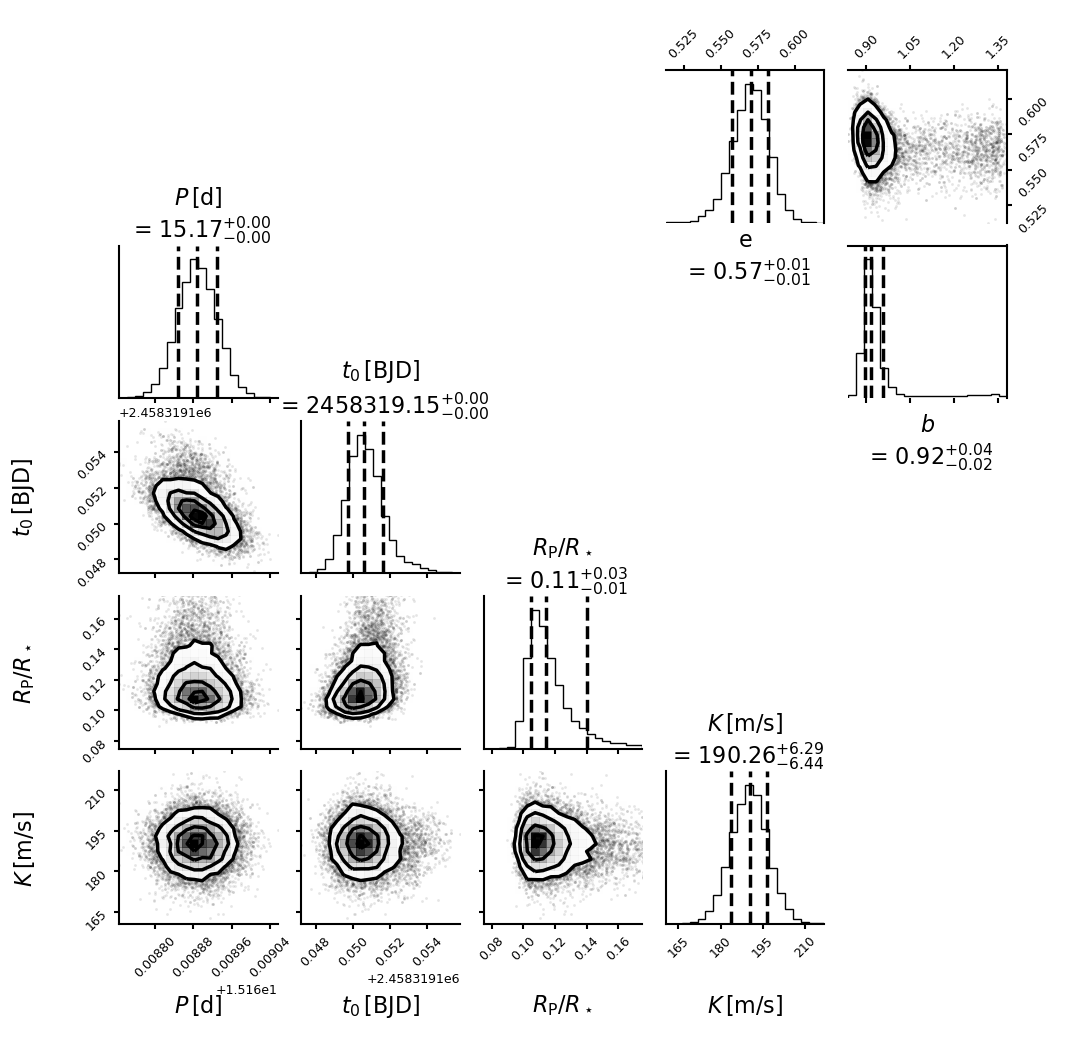

In [409]:
figAll

## phased photometry plots

In [163]:
# from DianaScripts.plots_lc import plot_phasedLC
# plot_phasedLC(out_folder)

[None, None]

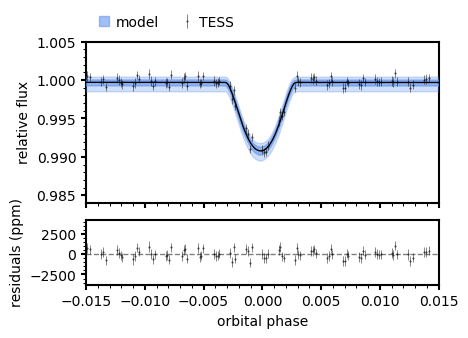

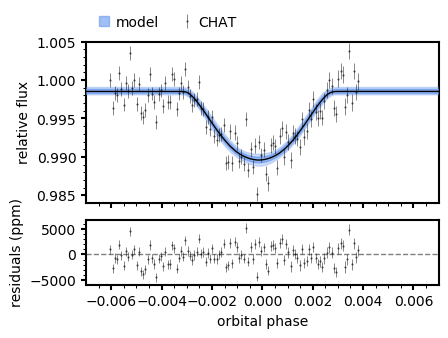

In [44]:
phasedPlots = plots.plot_phasedPhotometry(dataset, results, instrument=None)
[phasedPlots[inst][1][0].set_ylim([0.984, 1.005]) for inst in phasedPlots] # same y limits for all instruments
[phasedPlots[inst][0].savefig(out_folder + 'phasedPhot_{}.pdf'.format(aux.label(inst))) for inst in phasedPlots]

## print Latex tables

In [10]:
import latextable
import fileinput

In [125]:
# latextable.print_prior_table(dataset)
# latextable.print_posterior_table(dataset, results, precision=2)

writing to out/39_tess+chat+feros+GP/posterior_table.tex.
% These params were not able to be latexifyed
% ['unnamed' 'loglike']


### print RV data table

In [269]:
activityFile = 'data/TIC237913194_activity.dat'
feros_dat = np.genfromtxt(activityFile, names=True)
feros_dat = pd.DataFrame(feros_dat).replace(-999, np.nan)
feros_dat.head()

,obname,BJD_OUT,RV,RV_E,BS,BS_E,FWHM,instrument,pipeline,resolution,T_eff,logg,Z,Vsini,XC_MIN,DISP,TEXP,SNR_R,ccf_file,HALPHA,HALPHA_E,CA_II_S,CA_II_E,S_MW,S_MW_E,LOG_RHK,LOGRHK_E,NA_II,NA_II_E,HE_I,HE_I_E
0,NaN,2.458670e+06,29.5357,0.0087,-0.016,0.012,9.8808,NaN,NaN,50000.0,NaN,NaN,NaN,NaN,0.65,4.3,1200.0,65.0,NaN,0.1070,0.0031,0.1022,0.0134,0.1286,0.0156,-5.2440,0.1884,0.2859,0.0058,0.4999,0.0073
1,NaN,2.458671e+06,29.5191,0.0100,-0.014,0.013,9.9256,NaN,NaN,50000.0,NaN,NaN,NaN,NaN,0.65,4.3,1200.0,56.0,NaN,0.1036,0.0030,0.1749,0.0371,0.2093,0.0415,-4.7332,0.1545,0.2751,0.0059,0.5009,0.0076
2,NaN,2.458673e+06,29.5331,0.0122,0.014,0.016,9.9335,NaN,NaN,50000.0,NaN,NaN,NaN,NaN,0.65,4.3,1200.0,44.0,NaN,0.1122,0.0044,0.1279,0.0246,0.1571,0.0278,-4.9903,0.1871,0.2845,0.0086,0.5111,0.0112
3,NaN,2.458719e+06,29.5051,0.0075,-0.006,0.011,9.9168,NaN,NaN,50000.0,NaN,NaN,NaN,NaN,0.65,4.3,1200.0,79.0,NaN,0.1068,0.0022,0.1069,0.0097,0.1338,0.0118,-5.1853,0.1241,0.2834,0.0042,0.5108,0.0060
4,NaN,2.458722e+06,29.5282,0.0073,-0.000,0.011,9.9342,NaN,NaN,50000.0,NaN,NaN,NaN,NaN,0.65,4.3,1200.0,82.0,NaN,0.1082,0.0021,0.0994,0.0091,0.1254,0.0112,-5.2841,0.1475,0.2889,0.0040,0.5000,0.0057


In [277]:
latextable.print_RVtable(activityFile, out_folder)

--------------------------------------

## calculate derived parameters

In [14]:
get_planetaryparams(dataset, results, mass_star=[m_s,m_s_e],
                                  radius_star=[r_s,r_s_e], teff_star=teff_star, vsini_star=vsini_star)

In [93]:
l = sorted([p for p in results.posteriors['posterior_samples'].keys()])



val, valup, valdown = juliet.utils.get_quantiles(
            results.posteriors['posterior_samples'][l[0]])

1.1046423241129084e-06

In [ ]:
## obtain the radius of the planet -- requires r_s
i_transit=1
if r_s is not None and ('p_p{}'.format(i_transit) in results.posteriors['posterior_samples'].keys() or 'p_p{}'.format(i_transit) in dataset.priors.keys()):
    try:
        p = results.posteriors['posterior_samples']['p_p{}'.format(i_transit)]
    except KeyError:
        print('gna')

    results.posteriors['posterior_samples']['radius_m_p{}'.format(i_transit)] = p * r_s*solarrad2m
#     results.posteriors['posterior_samples']['radius_re_p{}'.format(i_transit)] = results.posteriors['posterior_samples']['radius_m_p{}'.format(i_transit)]/earthrad2m
#     results.posteriors['posterior_samples']['radius_rj_p{}'.format(i_transit)] = results.posteriors['posterior_samples']['radius_m_p{}'.format(i_transit)]/jupiterrad2m

rJup = results.posteriors['posterior_samples']['radius_m_p{}'.format(i_transit)]/jupiterrad2m

<IPython.core.display.Javascript object>


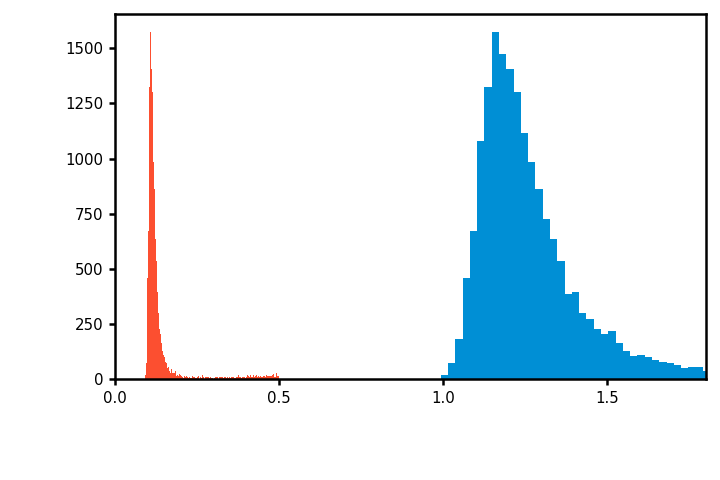

(0, 1.8)

In [564]:
h = plt.hist(rJup, bins=200)
hh = plt.hist(results.posteriors['posterior_samples']['p_p{}'.format(i_transit)], bins=200)
plt.xlim(0,1.8)

In [566]:
np.quantile(results.posteriors['posterior_samples']['p_p{}'.format(i_transit)], .84)

0.14032087882330987

## phased RV plots

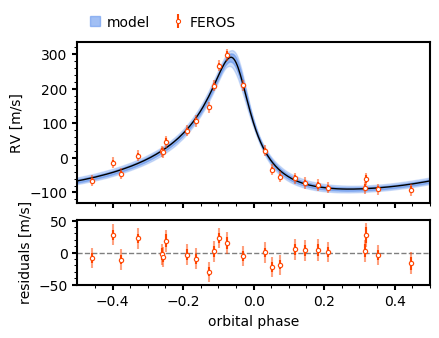

In [56]:
phasedRV = plots.plot_phasedRV(results)

In [57]:
[phasedRV[inst][0].savefig(out_folder + 'phasedRV_{}.pdf'.format(aux.label(inst))) for inst in phasedRV]

[None]

# activity indicators


In [49]:
activityFile = 'data/TIC237913194_activity.dat'

<IPython.core.display.Javascript object>


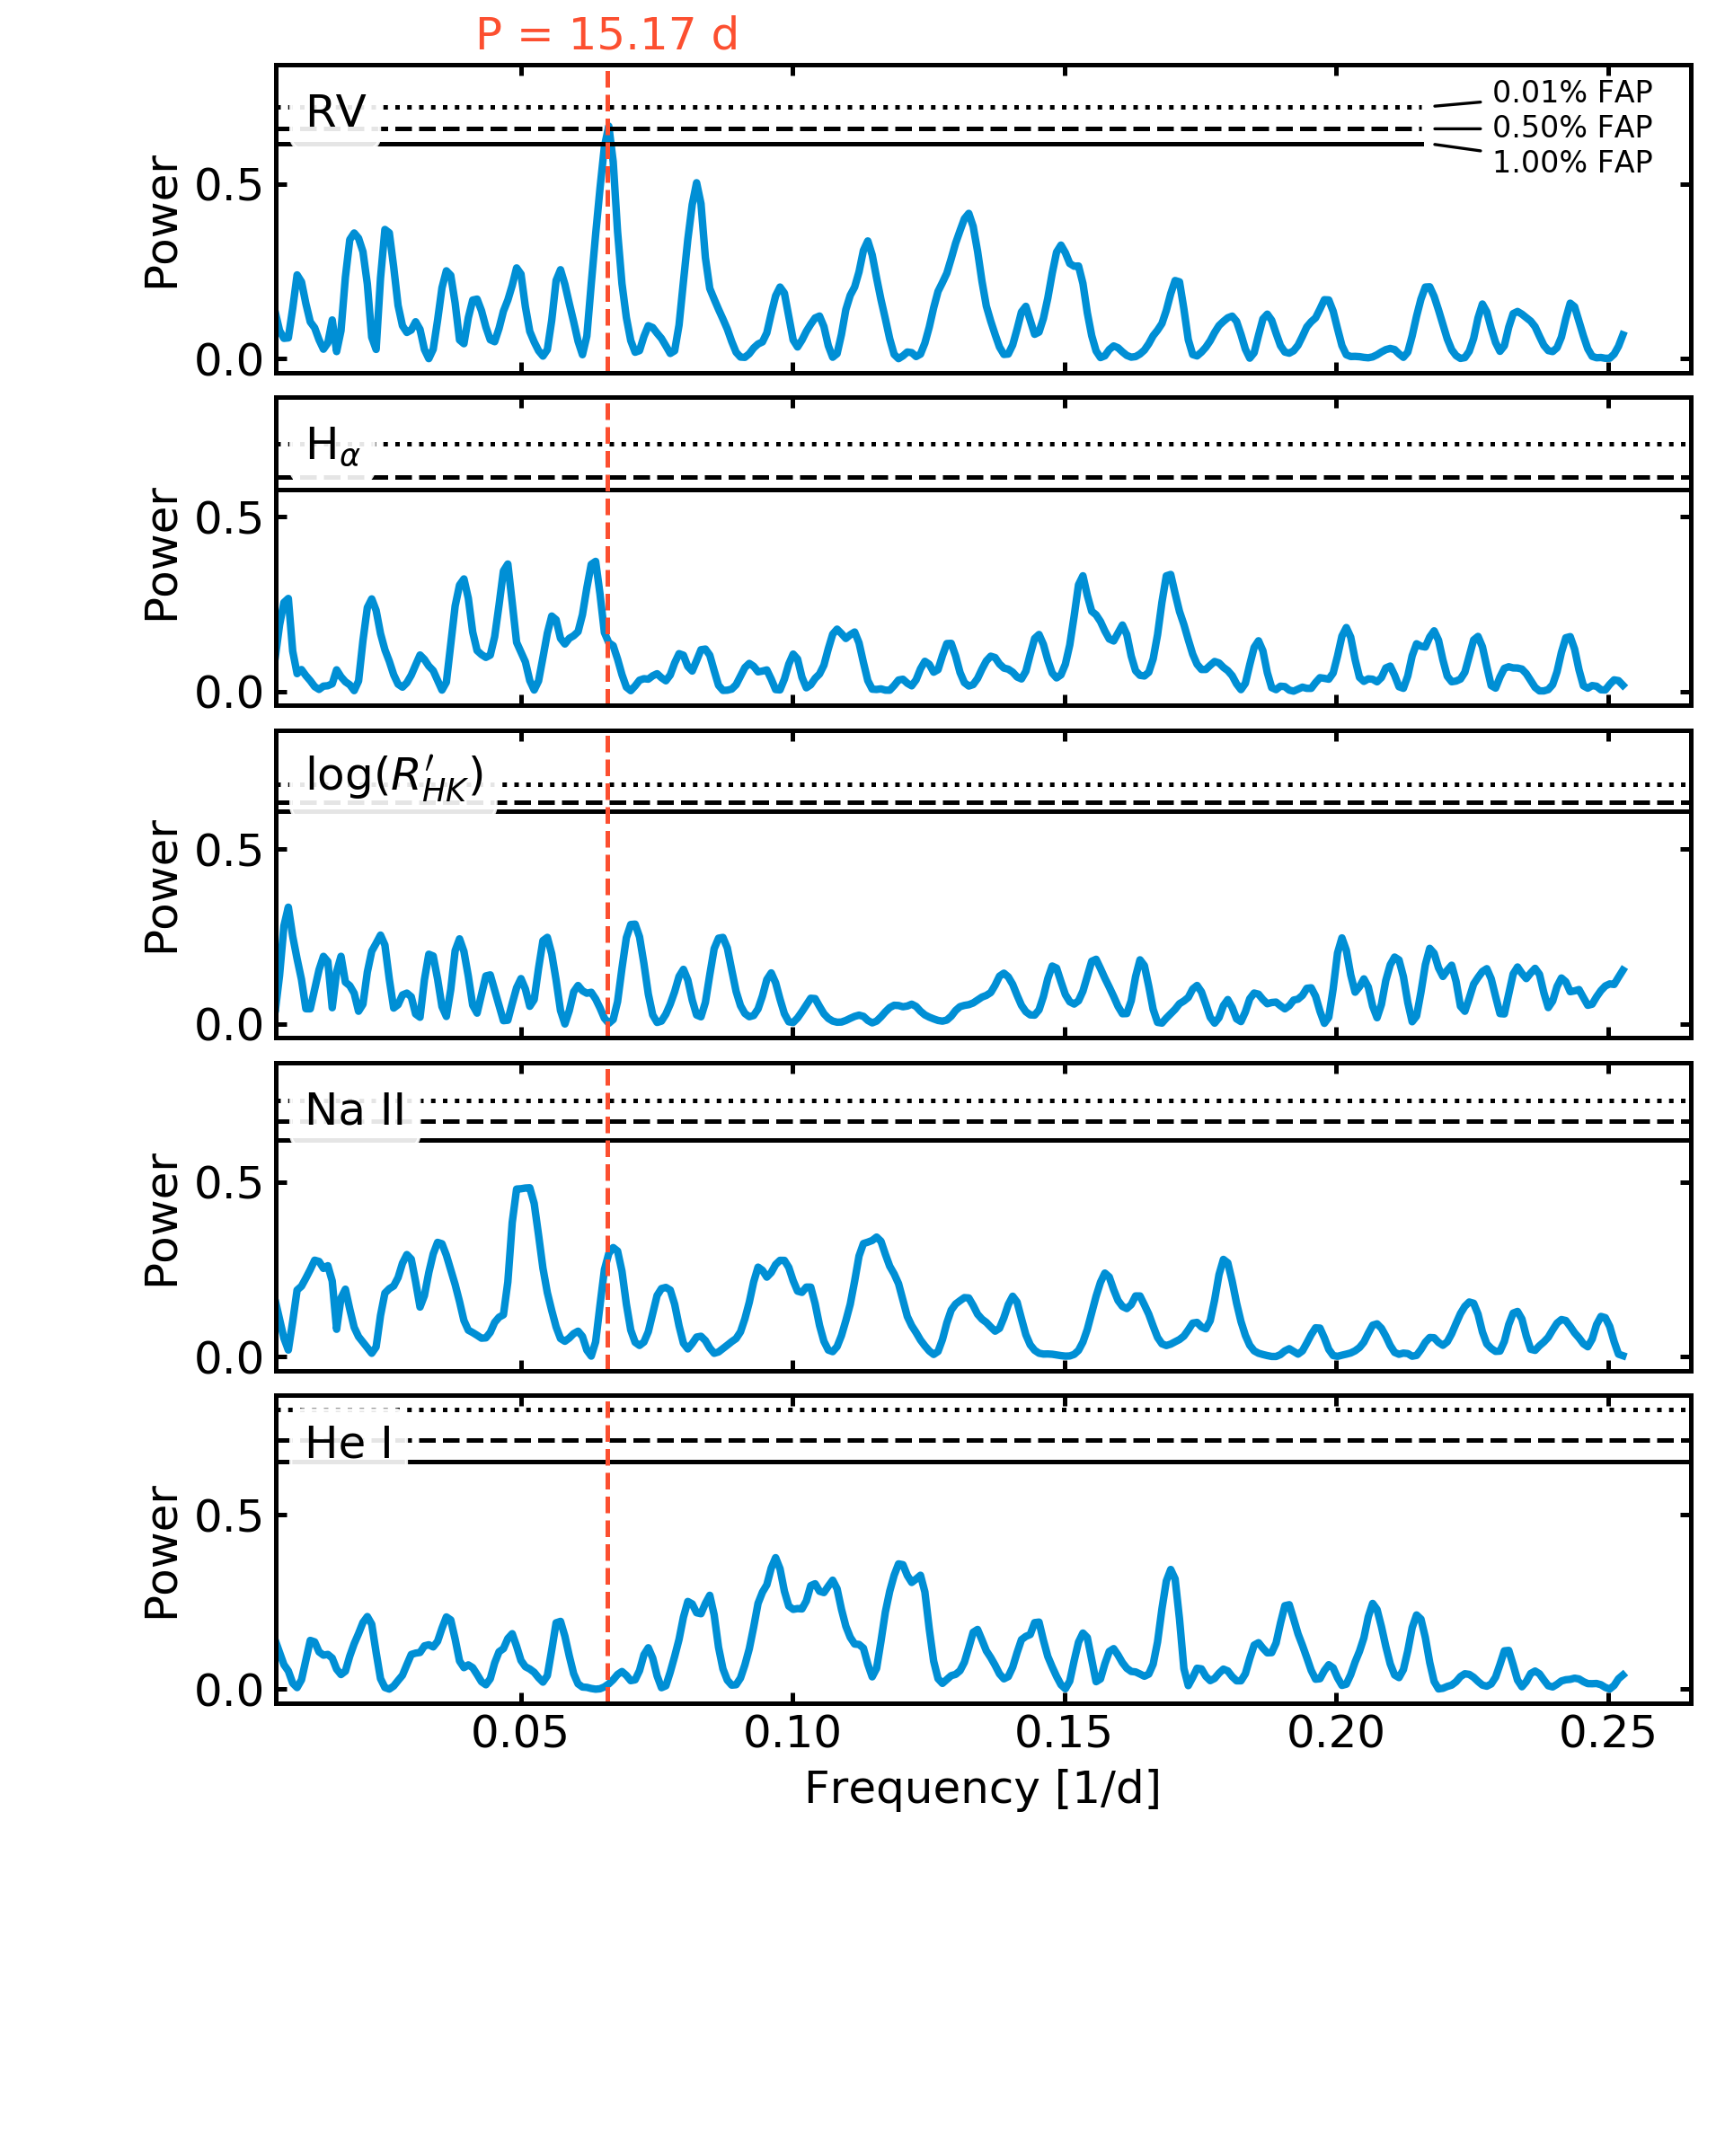

(<Figure size 800x1000 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a4fdd7090>,
       dtype=object))

In [570]:
plots.plot_periodograms(activityFile, out_folder, results, saveFig=True)

Text(0, 0.5, 'LOG RHK')

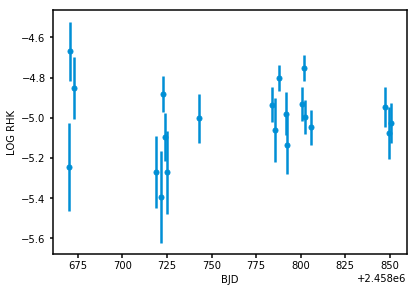

In [112]:
# log RHK timeseries
plt.errorbar(feros_dat['BJD_OUT'], feros_dat['LOG_RHK'], yerr=feros_dat['LOGRHK_E'], fmt='o')
plt.xlabel('BJD')
plt.ylabel('LOG RHK')

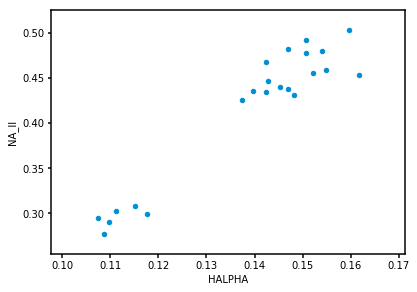

In [114]:
feros_dat.plot.scatter('HALPHA', 'NA_II')

## Check Bisector Span

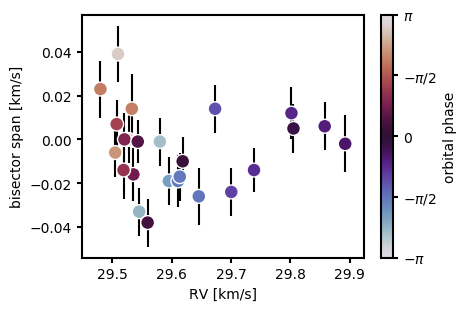

In [54]:
fig, ax = plots.plot_RV_BS(activityFile, out_folder, results)

In [55]:
# fig.savefig(out_folder + '/RV-BS.pdf')

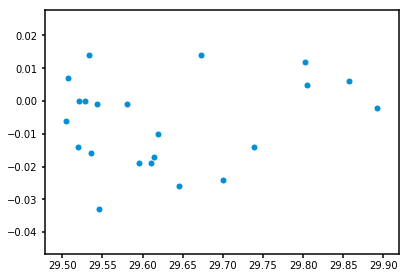

In [120]:
plt.scatter(feros_dat.phase, feros_dat.BS)

In [124]:
from scipy.stats import spearmanr, pearsonr

spearmanr(feros_dat.phase, feros_dat.BS)
# pearsonr(feros_dat.phase, feros_dat.BS)

SpearmanrResult(correlation=0.38394157672504353, pvalue=0.07772241962412424)

# Phase curves
use spiderman package to produce a phase curve

In [35]:
results.posteriors['posterior_samples'].keys()

dict_keys(['unnamed', 'loglike', 'P_p1', 't0_p1', 'p_p1', 'b_p1', 'sesinomega_p1', 'secosomega_p1', 'rho', 'q1_TESSERACT+TESS', 'q2_TESSERACT+TESS', 'sigma_w_TESSERACT+TESS', 'mflux_TESSERACT+TESS', 'GP_sigma_TESSERACT+TESS', 'GP_timescale_TESSERACT+TESS', 'q1_CHAT+i', 'sigma_w_CHAT+i', 'mflux_CHAT+i', 'K_p1', 'mu_FEROS', 'sigma_w_FEROS', 'a_p1', 'ecc_p1', 'omega_p1', 'radius_m_p1', 'radius_re_p1', 'radius_rj_p1', 'incl_p1', 'transittime_p1', 'semimajor_au_p1', 'rm_p1', 'teq_p1', 'insolation_p1', 'msini_kg_p1', 'msini_me_p1', 'msini_mj_p1', 'mass_kg_p1', 'mass_me_p1', 'mass_mj_p1', 'gravity_p1', 'rho_kgm3_p1', 'rho_gcm3_p1'])

In [619]:
import spiderman as sp

use values from preliminary fit. Neglect planetary limb darkening.

In [1240]:
spider_params = sp.ModelParams(brightness_model="zhang")
spider_params.n_layers= 7

def median_pstr(results, param):
    """extract median of posterior distribution"""
    return np.median(results.posteriors['posterior_samples'][param])
pstr = {}
for key in ['t0_p1', 'P_p1']:
    pstr[key] = median_pstr(results, key)

spider_params.t0= pstr['t0_p1']              # Central time of PRIMARY transit [days]
spider_params.per= pstr['P_p1']       # Period [days]
spider_params.a_abs= 0.1122        # The absolute value of the semi-major axis [AU]
# spider_params.a_abs= 0.05        # The absolute value of the semi-major axis [AU]

spider_params.inc= 87.6         # Inclination [degrees]
# spider_params.inc= 0.         # Inclination [degrees]

# spider_params.ecc= 0.6              # Eccentricity
spider_params.ecc= 0.              # Eccentricity

spider_params.w= 0.                 # Argument of periastron
# spider_params.w= 90.                 # Argument of periastron



spider_params.a= 22.2              # Semi-major axis scaled by stellar radius
# spider_params.a= 11.              # Semi-major axis scaled by stellar radius

spider_params.p_u1= 0               # Planetary limb darkening parameter
spider_params.p_u2= 0               # Planetary limb darkening parameter

temperatures from Teq estimate

In [1241]:
# spider_params.xi= 1.       # Ratio of radiative to advective timescale
spider_params.xi= 0.       # Ratio of radiative to advective timescale

spider_params.T_n= 683     # Temperature of nightside

spider_params.delta_T= 727  # Day-night temperature contrast
# spider_params.delta_T= 0# Day-night temperature contrast

spider_params.T_s = 5788    # Temperature of the star

# spider_params.l1 = 1.1e-6       # The starting wavelength in meters
# spider_params.l2 = 1.7e-6       # The ending wavelength in meters
spider_params.l1 = 0.6e-6       # The starting wavelength in meters
spider_params.l2 = 12e-6       # The ending wavelength in meters

careful, spidermabn uses zorder arguments. therefore the star is plotted over the planet even during transit phase (when plotting into the same axis repeatedly).

Brightness parameters incorrectly assigned
should be ['pb_d', 'pb_n']


NameError: name 'quit' is not defined

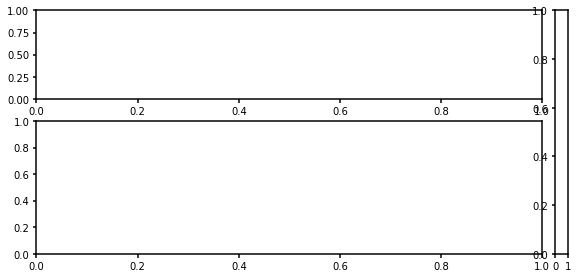

In [1255]:
# spider_params.plot_quad()

# spider_params.rp= 0.118            # Planet to star radius ratio

def plot_phasecurve(spider_params, phases=None):
    spider_params.rp= .67            # Planet to star radius ratio 


    fig = plt.figure(figsize=[9,4])
    grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.05, height_ratios=[1,1.5], width_ratios=[1, 0.025])
    axs = [None, None]
    axs[0] = fig.add_subplot(grid[0,0])
    axs[1] = fig.add_subplot(grid[1,0])
    cax = fig.add_subplot(grid[:,1])

    # fig, (cax, ax0, ax1)= plt.subplots(3, figsize=[15,5], gridspec_kw = {'height_ratios':[0.1,2,1]})
    # axs = [ax0, ax1]

    # deltaPhase = 1/8575 # delta to control plotted phases
    if phases == None:
        phases = np.linspace(0.,1., 24) - 0.012#deltaPhase

    # plot system
    show_cax = False
    # unify color-code limits
    lims = np.array([spider_params.get_lims(p, temp_map=False, use_phase=True) for p in phases])
    min_brightness =  min(lims[:,0])/2
    max_brightness =  max(lims[:,1])

    for i, p in enumerate(phases[::-1]):
        # iterate backwards trough phases because of overplotting
        if i > 0:
            show_cax = False
        axs[0] = spider_params.plot_system(t=p, ax=axs[0], use_phase=True, show_axes=False, 
                                       theme='white', show_cax=show_cax, temp_map=False,
                                          min_temp=min_brightness, max_temp=max_brightness)

    # plot colorbar
    cbardata = [np.linspace(min_brightness/max_brightness,1,1000)]
    figx, axx = plt.subplots()
    im = axx.imshow(cbardata, interpolation='none')
    # cbar = fig.colorbar(im, cax=cax, shrink=1., orientation='horizontal')
    cbar = fig.colorbar(im, cax=cax, shrink=1)
    cbar.set_label('relative brightness')
    plt.close(figx)

    axs[0].autoscale(tight=False)

    # plot phase curve for nominal xi, but using actual planet size
    spider_params.rp= 0.118
    phases_lc = np.linspace(+.02, .98, 1000)
    lc = spider_params.lightcurve(phases_lc, use_phase=True)
    axs[1].plot(phases_lc,lc -1, label=r'$\xi$ = 0')

    # plot phase curve for many different xi
    for spider_params.xi in np.linspace(0., 1, 20):
        lc = spider_params.lightcurve(phases_lc, use_phase=True)
        axs[1].plot(phases_lc,lc - 1, alpha=.1, c='k', lw=1.)
    axs[1].plot(phases_lc,lc - 1, alpha=.1, c='k', lw=1., label=r'$\xi = \mathcal{U}\,(0,1)$')

    [axs[1].axvline(p, ls='--', c='C2', lw=1.2, alpha=.66, zorder=-1) for p in phases]
    axs[1].set_xlabel('orbital phase')
    axs[1].set_ylabel('relative flux')
    axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    leg = axs[1].legend(loc='lower right', ncol=99, bbox_to_anchor=(1., 1.),
                          frameon=False, columnspacing=1.6)
    leg.legendHandles[1].set_alpha(.33)

    # subplots_adjust(left=None, bottom=None, right=None, top=1., wspace=None, hspace=None)
    return fig, axs


fig, axs = plot_phasecurve(spider_params)
axs[0].set_rasterized(True)
# fig.savefig(plotDir + 'phasecurve3.pdf', rasterized=True)

In [1174]:
# fig.savefig(plotDir + 'phasecurve3.pdf', rasterized=True)

maybe useful for a video:

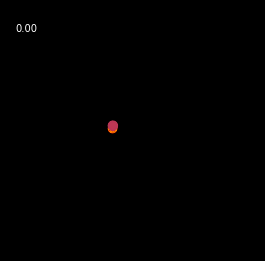

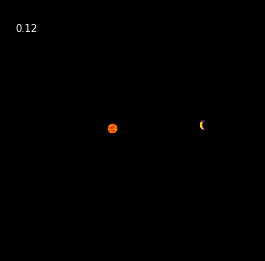

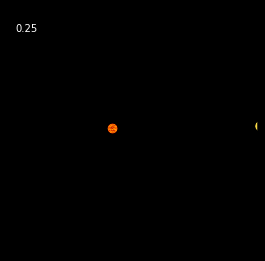

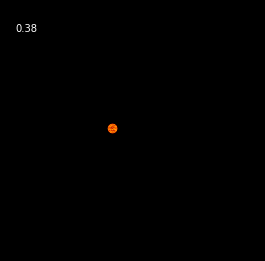

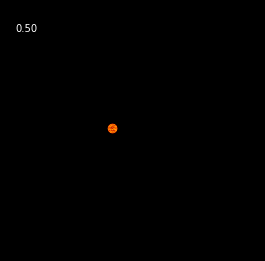

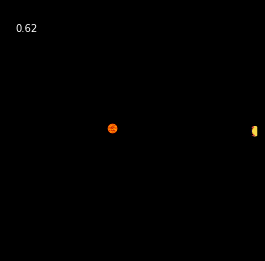

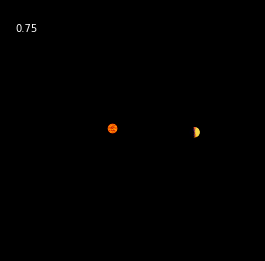

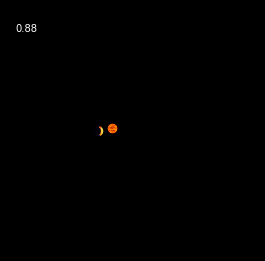

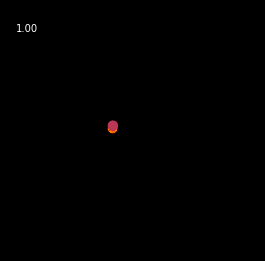

In [1275]:
params.rp= .95
for i, p in enumerate(phases[:]):
    ax = params.plot_system(t=p, use_phase=True, show_axes=False, 
                                   theme='black', show_cax=False, temp_map=False)
    ax.annotate('{:.2f}'.format(p), [0.02, 0.9], xycoords='axes fraction', color='white')
#     ax.autoscale(tight=False)
    ax.set_xlim(axs[0].get_xlim())
    ax.set_ylim(axs[0].get_ylim())

use different brightness model

In [1297]:
# params = params
# dummy = sp.ModelParams(brightness_model="two brightness")
# params.brightness_type = dummy.brightness_type

params = sp.ModelParams(brightness_model="hotspot_b")
params.n_layers= 7

def median_pstr(results, param):
    """extract median of posterior distribution"""
    return np.median(results.posteriors['posterior_samples'][param])
pstr = {}
for key in ['t0_p1', 'P_p1']:
    pstr[key] = median_pstr(results, key)

params.t0= pstr['t0_p1']              # Central time of PRIMARY transit [days]
params.per= pstr['P_p1']       # Period [days]
params.a_abs= 0.1122        # The absolute value of the semi-major axis [AU]
# params.a_abs= 0.05        # The absolute value of the semi-major axis [AU]

params.inc= 87.6         # Inclination [degrees]
# params.inc= 0.         # Inclination [degrees]

params.ecc= 0.6              # Eccentricity
# params.ecc= 0.              # Eccentricity

params.w= 0.                 # Argument of periastron
# params.w= 90.                 # Argument of periastron

params.a= 22.2              # Semi-major axis scaled by stellar radius
# params.a= 11.              # Semi-major axis scaled by stellar radius

params.p_u1= 0               # Planetary limb darkening parameter
params.p_u2= 0               # Planetary limb darkening parameter

# params.xi= 1.       # Ratio of radiative to advective timescale
params.xi= 0.       # Ratio of radiative to advective timescale

params.T_n= 683     # Temperature of nightside

params.delta_T= 727  # Day-night temperature contrast
# params.delta_T= 0# Day-night temperature contrast

params.T_s = 5788    # Temperature of the star

# params.l1 = 1.1e-6       # The starting wavelength in meters
# params.l2 = 1.7e-6       # The ending wavelength in meters
params.l1 = 0.6e-6       # The starting wavelength in meters
params.l2 = 12e-6       # The ending wavelength in meters


# params.p_T = 500
# params.pb_d = .5
# params.pb_n = .05


# for 'hotspot_b' model:
params.spot_b = 1000
params.p_b = 0.05 #frac of stellar brightness
params.la0 = 0
params.lo0 = 0
params.size = 90


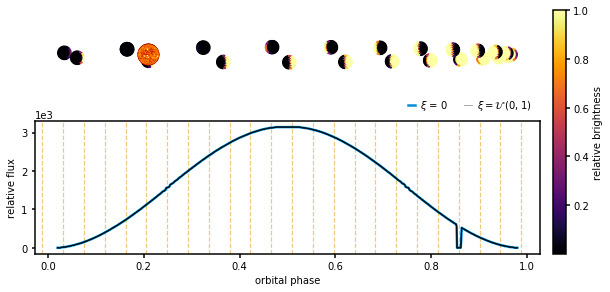

In [1298]:
phases = list(np.linspace(0., 1., 9, endpoint=True))
fig, axs = plot_phasecurve(params, phases=None)


# params.rp= .67
# params.plot_system(t=.83,  use_phase=True, show_axes=False, 
#                                        theme='white', show_cax=show_cax, temp_map=False)

## use starry package

In [167]:
starry.config.lazy = False

### Model a star-planet system

In [235]:
# estimate planet/star luminosity ratio
r_st = 1.09
r_pl = 0.118
Teff_st = 5788
Teff_pl = 974 # take averaged Teq for zero albedo (case of orbitally  averaged  heat  adjustment)
Teff_pl_hot = 1519 # best-case scenario: beta=0.5, instantaneous equilibration, temp at periastron.
Lratio = 0.5*(r_pl/r_st)**2*(Teff_pl/Teff_st)**4 #factor 1/2 because only half of the planet radiates
Lratio_hot = 0.5*(r_pl/r_st)**2*(Teff_pl_hot/Teff_st)**4
print('luminosity ratio = {:.1f} ppm'.format(Lratio*1e6))
print('luminosity ratio (hot case) = {:.1f} ppm'.format(Lratio_hot*1e6))

# define primary (star)
st = {
    'inc' : 90,
    'obl' : 0.,
    'm' : 1.026,
    'r' : r_st,
    'prot' : 1.,
    'veq' : 2.18e3,
    'u1' : .65,
    'u2' : 0.
} 

# define secondary (planet)
pl = {
    'm': 0.002,
    'r': r_pl,
    'L' : Lratio,
    'ecc': 0.57,
    'omega': np.median(results.posteriors['posterior_samples']['omega_p1']),
    'inc': 87.6,
#     'inc': 90.0,
    'prot': 4.3,
    'porb': np.median(results.posteriors['posterior_samples']['P_p1']),
    't0':  np.median(results.posteriors['posterior_samples']['t0_p1']),
    'theta0' : 0          # hotspot offset
}

luminosity ratio = 4.7 ppm
luminosity ratio (hot case) = 27.8 ppm


In [169]:
t = times_lc['TESSERACT+TESS']
flux = fluxes['TESSERACT+TESS']
flux_err = fluxes_error['TESSERACT+TESS']

model_prediction = results.lc.evaluate('TESSERACT+TESS', t = t, GPregressors = t)
t_detr, flux_detr, flux_err_detr = t, flux/model_prediction, flux_err/model_prediction
plt.scatter(t_detr, flux_detr, s=2)
plt.show()

In [175]:
rv=False
# rv = True


def get_luminosity(r, T):
    return 4*np.pi*r**2*c.sigma_sb*T**4
lum_st = get_luminosity(st['r'], Teff_st) 
lum_pl = 0.5*get_luminosity(pl['r'], Teff_pl) # assume only half of planetary surface radiates

# Instantiate the star; all its parameters are assumed
# to be known exactly
A = starry.Primary(
    starry.Map(ydeg=0, udeg=2, amp=1., inc=st['inc'], veq=st['veq'], obl=st['obl'], rv=rv),
    m=st['m'], r=st['r'], prot=st['prot'])
A.map[1] = st['u1'] 
A.map[2] = st['u2'] 

# Instantiate the planet. fix also the luminosity and the hot spot offset.
b = starry.Secondary(
    starry.Map(ydeg=1, udeg=0, amp=Lratio, inc=90.0, obl=0.0, rv=rv, veq=0),
    m=pl['m'],
    r=pl['r'],
    ecc=pl['ecc'],
    omega=pl['omega'],
    inc=pl['inc'],
#     prot=pl['prot'],
    prot=pl['prot'],
    porb=pl['porb'],
    t0 = pl['t0'],
    theta0 = pl['theta0']) 

# another version for the 'hot planet' scenario, same except for the luminosity ratio
b_hot = starry.Secondary(
    starry.Map(ydeg=1, udeg=0, amp=Lratio_hot, inc=90.0, obl=0.0, rv=rv, veq=0),
    m=pl['m'],
    r=pl['r'],
    ecc=pl['ecc'],
    omega=pl['omega'],
    inc=pl['inc'],
#     prot=pl['prot'],
    prot=pl['prot'],
    porb=pl['porb'],
    t0 = pl['t0'],
    theta0 = pl['theta0']) 

# give the planet a simple dipole map (Y_1,0) with peak brightness at the substellar point
b.map[1, 0] = 0.5 
b.theta0 = 180.0 + 0.    # fix hot spot to substellar point at peri

b_hot.map[1, 0] = 0.5
b_hot.theta0 = 180.

# A.map.show()
# b.map.show()

Invalid keyword `inc` in call to `reset()`. Ignoring.
Invalid keyword `veq` in call to `reset()`. Ignoring.
Invalid keyword `obl` in call to `reset()`. Ignoring.
Pre-computing some matrices... Done.
Invalid keyword `veq` in call to `reset()`. Ignoring.
Pre-computing some matrices... Done.
Invalid keyword `veq` in call to `reset()`. Ignoring.


In [176]:
t = np.linspace(pl['t0'], pl['t0'] + pl['porb'], 1000)

# combine planet and star to a system
system = starry.System(A, b)
system_hot = starry.System(A, b_hot)

In [188]:
system.show(t[::10], window_pad=5.0,)

Compiling `render`... Done.


generate a synthetic light curve

In [177]:
t = np.linspace(pl['t0'] - pl['porb']/2, pl['t0'] + pl['porb']/2, 1000)[1:-1]
flux_true = system.flux(t)
ferr = 842*1e-6
# flux = flux_true + ferr * np.random.randn(len(t))
plt.figure(figsize=(12, 5))
# plt.plot(t, flux, "k.", alpha=0.3, ms=3)
plt.plot(t[5:-5], flux_true[5:-5])
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

Compiling `X`... Done.


### when does the 2nd eclipse occur?

at which phase does the 2nd eclipse occur?

In [178]:
t = np.linspace(pl['t0'] - pl['porb']/2, pl['t0'] + pl['porb']/2, 1000)[1:-1]
P = np.median(results.posteriors['posterior_samples']['P_p1'])
t0 = np.median(results.posteriors['posterior_samples']['t0_p1'])
phases = juliet.utils.get_phases(t, P, t0)
phase_eclipse = phases[np.argmin(system.flux(t, total=False)[1])]

In [179]:
t_eclipse = (1 + phase_eclipse)*P# - np.median(results.posteriors['posterior_samples']['t0_p1'])
print(t_eclipse)

12.519267335467445


### plot phase curve (only the planet flux)

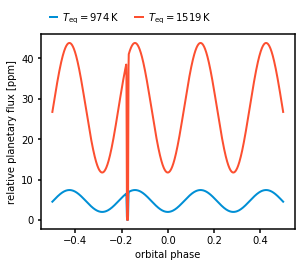

In [255]:
flux_star, flux_planet = system.flux(t, total=False)
flux_star_hot, flux_planet_hot = system_hot.flux(t, total=False)

fig, ax = plt.subplots(figsize=figsize)
# ax.plot(t, flux_planet*1e6)
# ax.set_xlabel("time [BJD]")
# ax.set_ylabel("relative planetary flux [ppm]");
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# fig.show()

fig, ax = plots.plot_phasecurve(t, flux_planet, results, fig=fig, ax=ax, label='$T_\mathrm{{eq}}={}\,\mathrm{{K}}$'.format(Teff_pl))
fig, ax = plots.plot_phasecurve(t, flux_planet_hot, results, fig=fig, ax=ax, label='$T_\mathrm{{eq}}={}\,\mathrm{{K}}$'.format(Teff_pl_hot))
plt.legend(loc='lower left', ncol=99, bbox_to_anchor=(0., 1.),
                                frameon=False, columnspacing=1.6)

In [256]:
# fig.savefig(out_folder + 'phasecurve_planetonly_hotcold.pdf')

### show system orientation

In [52]:
# plot the system
x, y, z = system.position(t)

plt.plot(t, x[1], label="x")
plt.plot(t, y[1], label="y")
plt.plot(t, z[1], label="z")
plt.ylabel("position [R$_\star$]")
plt.xlabel("t [days]")
plt.legend()




Compiling `position`... Done.


In [53]:
fig, ax = plt.subplots(1, figsize=[figsize[1], figsize[1]]) #equal aspect ratio
# A.map.show(ax=ax, grid=False, figsize=figsize, cmap='plasma')
ax.plot(x[1], z[1], c='gray')
ax.scatter(0, 0, marker="*", color="k", s=200, zorder=10)
ax.vlines(x=0, ymin=-33, ymax=20, color='C0',ls='--', lw=1.5, clip_on=False)
# ax.axvline(x=0, color='gray',ls='--', lw=2, clip_on=False)
ax.annotate('', xy=(0,-34),  xycoords='data',
            xytext=(0, -40),
            arrowprops=dict(arrowstyle="->"), annotation_clip=False)



ax.set_xlabel(r"x [R$_\star$]")
ax.set_ylabel(r"z [R$_\star$]")
ax.set_xlim([-13,43])
ax.set_ylim([-29,20])
# ax.set_title('top')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 15))
ax.spines['bottom'].set_position(('outward', 15))
ax.set_aspect("equal")

xticks = ax.xaxis.get_major_ticks()
xticks[2].label1.set_visible(False) # hide 'zero' ticklabel
xticks[2].tick1On = False # hide 'zero' ticklabel


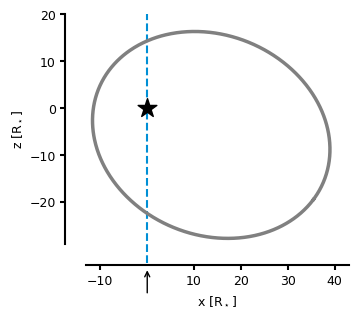

In [54]:
fig

In [55]:
# fig.savefig(out_folder + 'systemOrientation_top.pdf')

### make a video

In [56]:
b.r = .5
mpl.rc('lines', linewidth = 2)
system.show(t=np.linspace(0, pl['porb'], 200), window_pad=40, figsize=(30, 20))#, cmap='hot', file=out_folder + 'starry_animated.avi', html5_video=False)

### Fitting phase curve to TESS photometry (just a test, not sensible) 
either raw (t, flux, flux_err) or detrended (+_detr)

In [ ]:
t = times_lc['TESSERACT+TESS']
flux = fluxes['TESSERACT+TESS']
flux_err = fluxes_error['TESSERACT+TESS']

model_prediction = results.lc.evaluate('TESSERACT+TESS', t = t, GPregressors = t)
t_detr, flux_detr, flux_err_detr = t, flux/model_prediction, flux_err/model_prediction

In [613]:
with pm.Model() as model:

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    offset = pm.Normal("offset", 0.0, 50.0, testval=0.11)
    log_amp = pm.Normal("log_amp", -4.0, 2.0, testval=-3.91)
#     log_amp = -2.

    # Instantiate the star; all its parameters are assumed
    # to be known exactly
    A = starry.Primary(
        starry.Map(ydeg=0, udeg=2, amp=1.0, inc=st['inc'], obl=st['obl']), m=st['m'], r=st['r'], prot=st['prot'])
    A.map[1] = st['u1'] 
    A.map[2] = st['u2'] 

    # Instantiate the planet. Everything is fixed except for
    # its luminosity and the hot spot offset.
    b = starry.Secondary(
        starry.Map(ydeg=1, udeg=0, amp=10 ** log_amp, inc=90.0, obl=0.0),
        m=pl['m'],
        r=pl['r'],
        ecc=pl['ecc'],
        omega=pl['omega'],
        inc=pl['inc'],
        prot=pl['prot'],
        porb=pl['porb'],
        t0 = pl['t0']
    ) 
    
    b.map[1, 0] = 0.5
    b.theta0 = 180.0 + offset

    # Instantiate the system as before
    sys = starry.System(A, b)

    # Our model for the flux
    flux_model = pm.Deterministic("flux_model", sys.flux(t))

    # This is how we tell `pymc3` about our observations;
    # we are assuming they are ampally distributed about
    # the true model. This line effectively defines our
    # likelihood function.
    pm.Normal("obs", flux_model, sd=flux_err, observed=flux)

Invalid keyword `inc` in call to `reset()`. Ignoring.
Invalid keyword `obl` in call to `reset()`. Ignoring.
Pre-computing some matrices... Done.


Great! The first thing we usually do is run this model through an optimizer (which is usually fast, since starry computes derivatives):


In [614]:
%%time
with model:
    map_soln = exoplanet.optimize()

optimizing logp for variables: [log_amp, offset]
36it [00:00, 52.80it/s, logp=9.084502e+03] 

CPU times: user 3.23 s, sys: 79.7 ms, total: 3.31 s
Wall time: 1.98 s



message: Optimization terminated successfully.
logp: 8902.266839849814 -> 9084.501902137446


best fit model:

offset: 130.05158040399968
log_amp: -3.7691960787350958


<IPython.core.display.Javascript object>


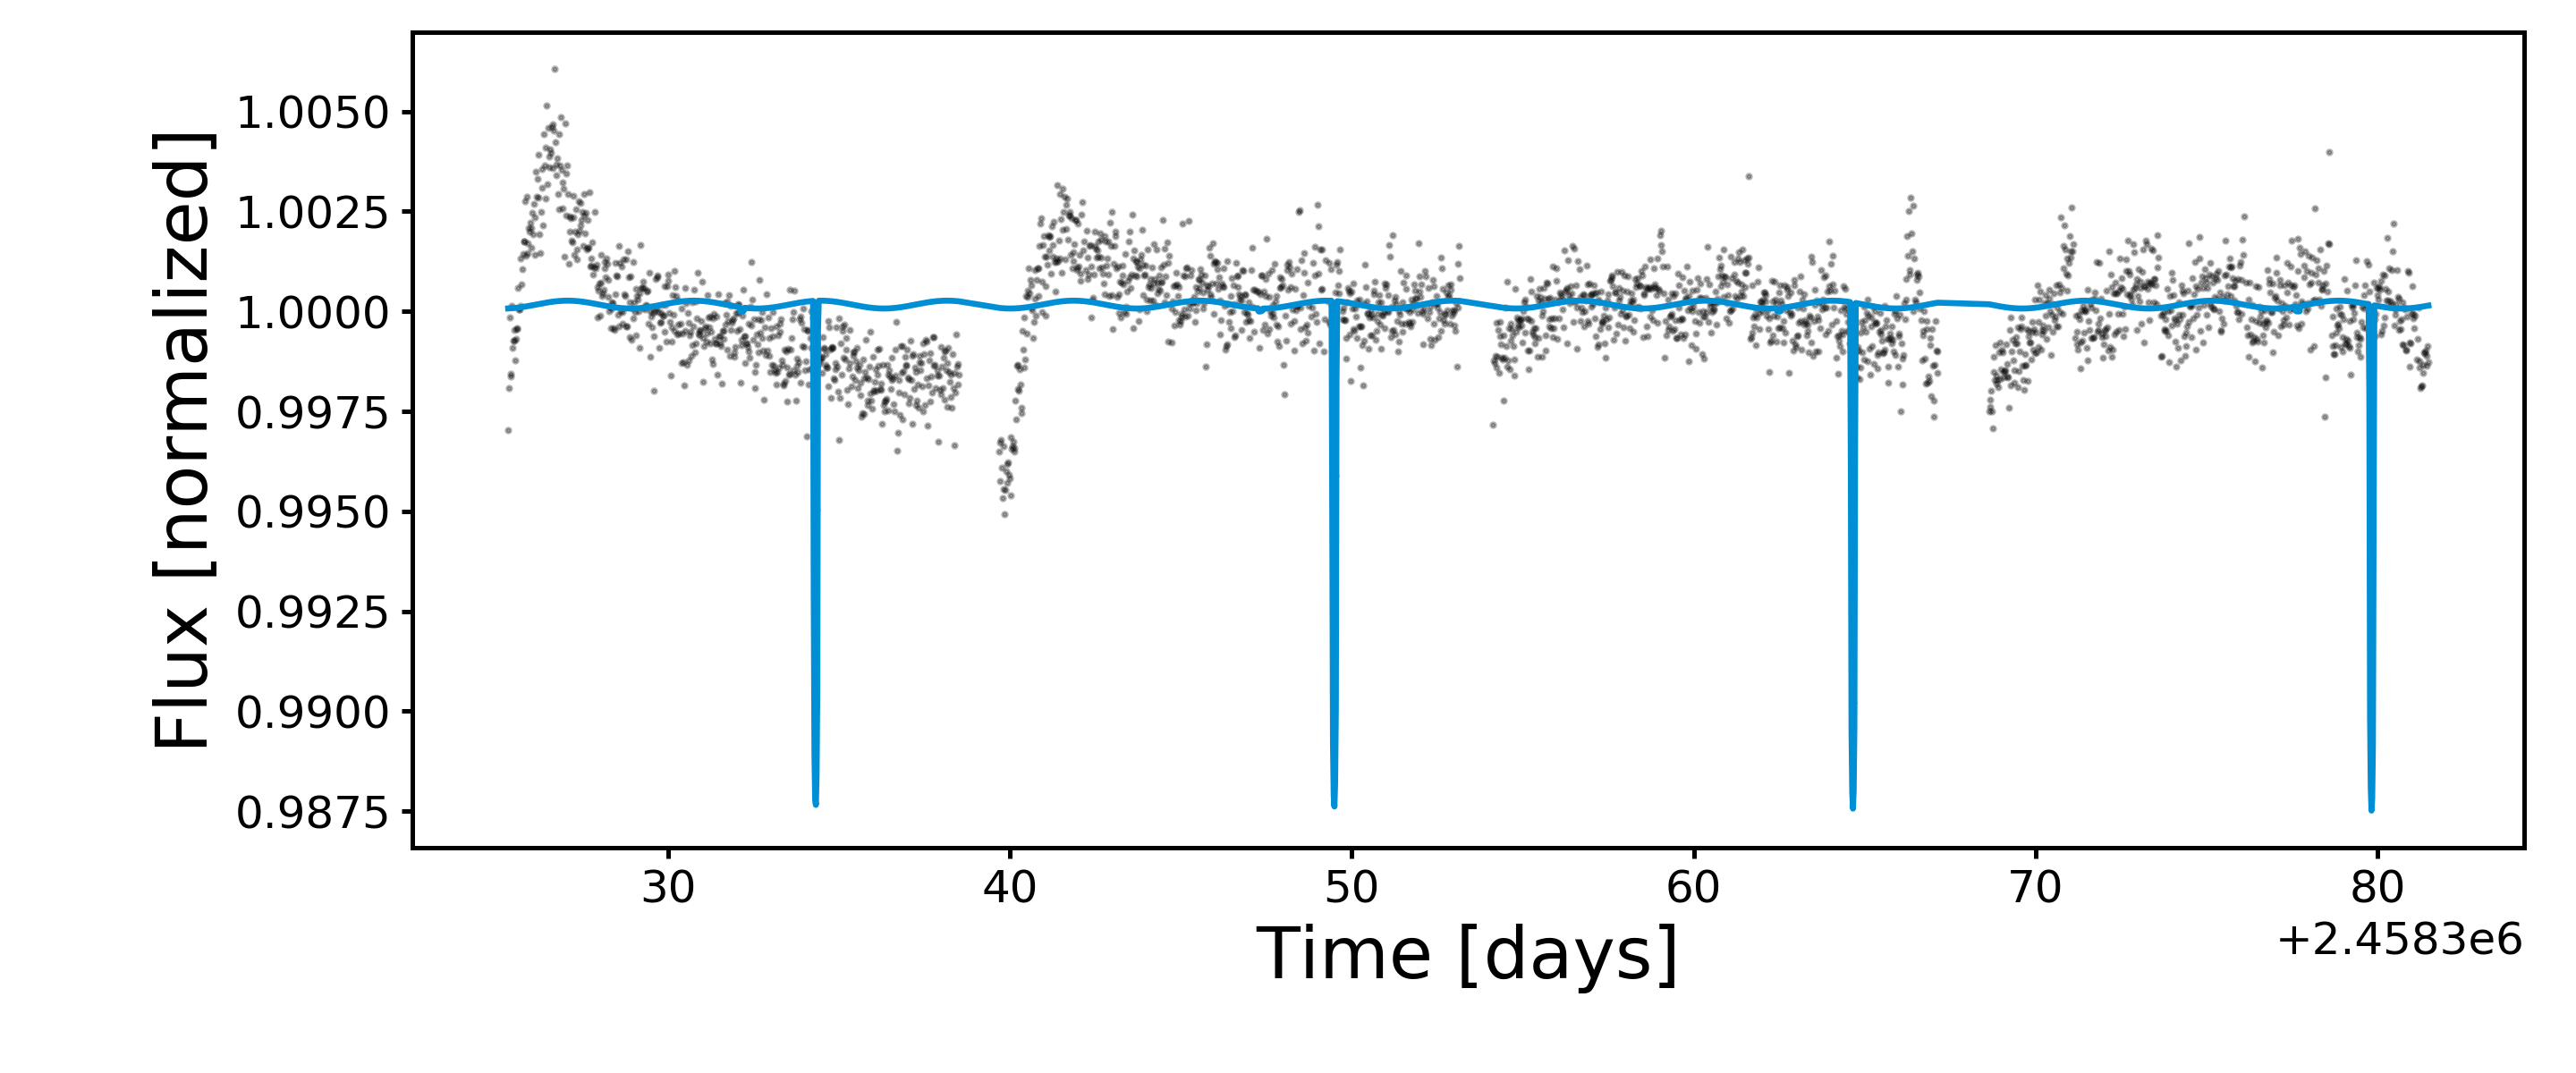

In [618]:
print("offset:", map_soln["offset"])
print("log_amp:", map_soln["log_amp"])

plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=0.3, ms=3)
plt.plot(t, map_soln["flux_model"])
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);
plt.show()

#### get posteriors

In [616]:
%%time
with model:
    trace = pm.sample(
        tune=250,
        draws=500,
        start=map_soln,
        chains=4,
        cores=1,
        step=exoplanet.get_dense_nuts_step(target_accept=0.9),
    )

# sampling summary
pm.summary(trace, var_names=["log_amp", "offset"])

Sequential sampling (4 chains in 1 job)
NUTS: [log_amp, offset]
Sampling chain 3, 0 divergences: 100%|██████████| 750/750 [00:05<00:00, 134.07it/s]


CPU times: user 1min 36s, sys: 1.73 s, total: 1min 38s
Wall time: 33.4 s


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
log_amp,-3.774,0.029,-3.830,-3.722,0.001,0.001,1635.0,1632.0,1657.0,1146.0,1.0
offset,130.025,5.069,119.587,138.500,0.139,0.098,1329.0,1329.0,1329.0,1110.0,1.0


<IPython.core.display.Javascript object>


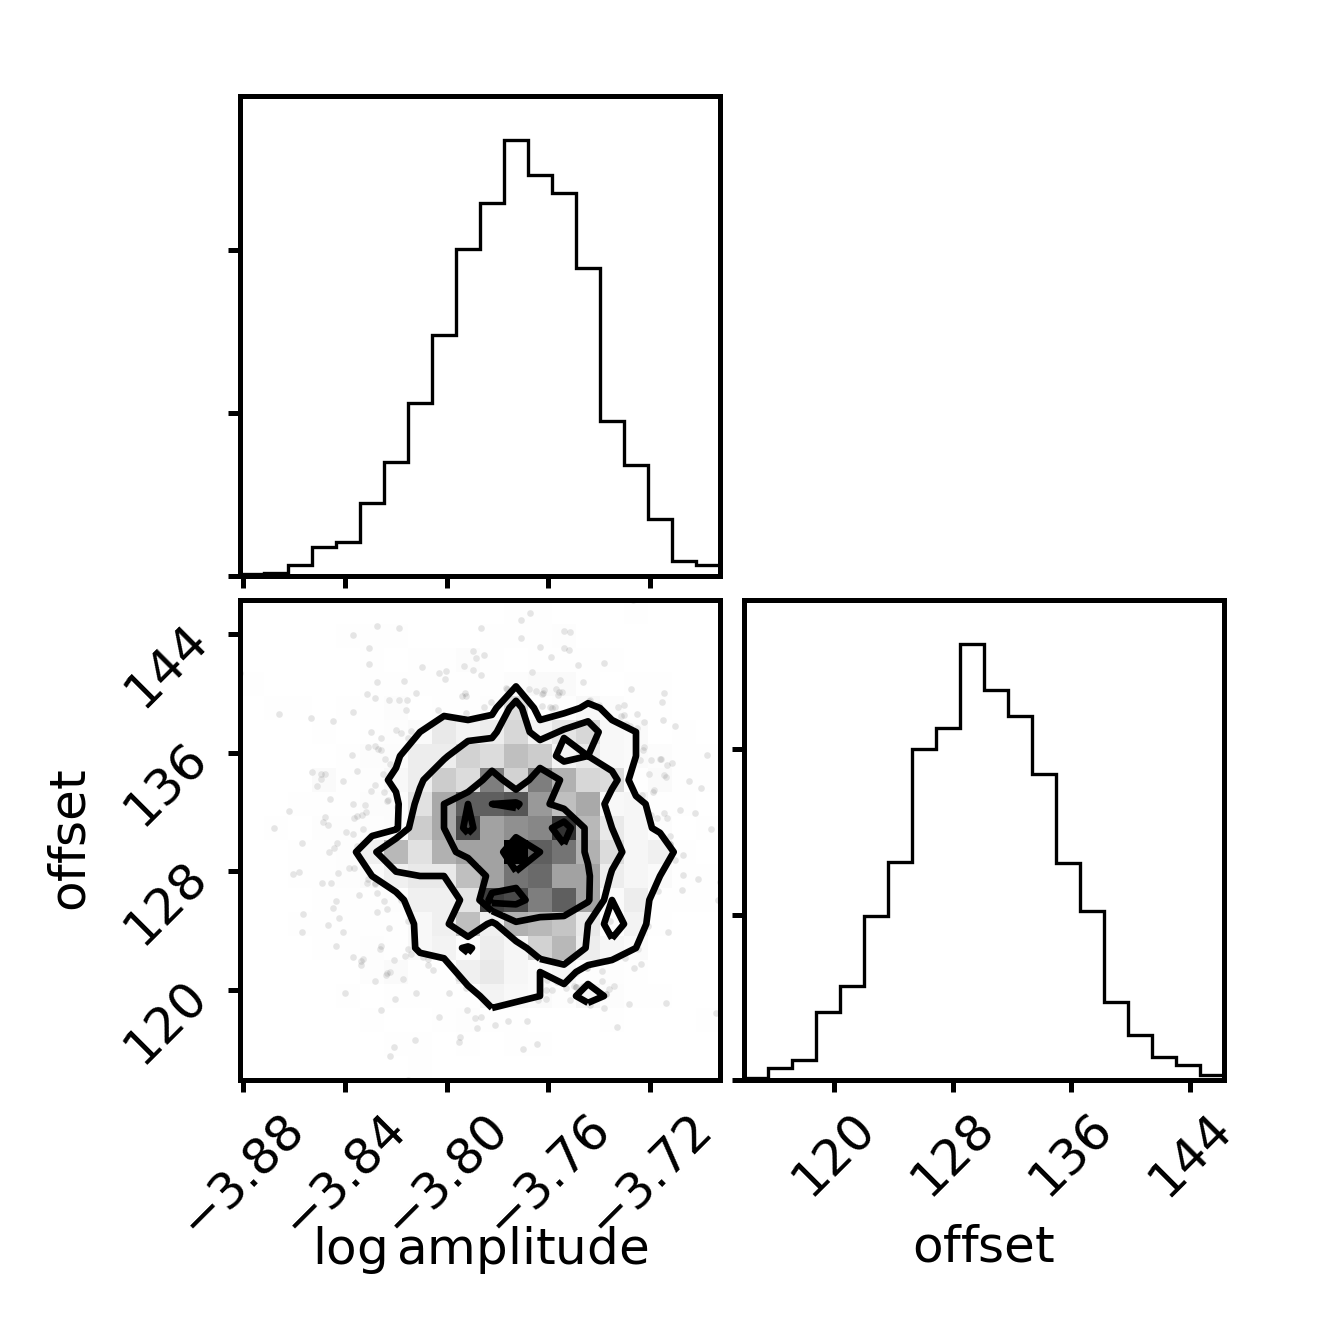

In [617]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["log_amp", "offset"])
corner.corner(
    np.array(samples),
#     truths=[log_amp_true, offset_true],
    labels=[r"$\log\,\mathrm{amplitude}$", r"$\mathrm{offset}$"],
);

# RM - Effect

In [178]:
starry.config.lazy = False
starry.config.quiet = True

In [179]:
# map = starry.Map(udeg=2, rv=True)

# map.inc = 90
# map.obl = 0
# map.veq = 1.0e4
# map.alpha = 0.3 # differential rotation shear (unitless)

# map[1] = 0.5
# map[2] = 0.25

# map.show(rv=True)

In [230]:
# use system from above
# SWITCH 'rv=True' on in definition of secondary body 'b' above!
# Define the system
sys = starry.System(A, b)
# A.map.show()

# Compute the flux & RV signal
# t = np.linspace(-0.5, 0.5, 1000)
t = np.linspace(pl['t0'] - .15, pl['t0'] + .15, 1000)
flux = sys.flux(t)
rv = sys.rv(t)

#remove linear trend as estimated from plot
def lin(x, m, b):
    return m*x + b
rv -= lin(t, m=-154, b=3.78581268e8)

# Plot it
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(t, flux)
ax[1].plot(t, rv)
ax[1].set_xlabel("time [days]", fontsize=24)
ax[0].set_ylabel("flux [normalized]", fontsize=24)
ax[1].set_ylabel("radial velocity [m / s]", fontsize=24);
# ax[1].plot(t, lin(t, m=-154, b=3.78581268e8), '--')   # subtracted linear trend



Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


TypeError: object of type 'TensorVariable' has no len()

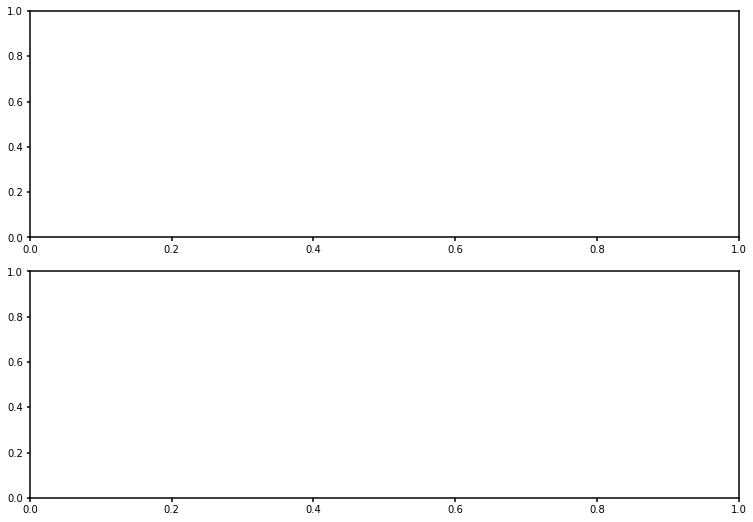

In [270]:
# # Define the star
# A = starry.Primary(
#     starry.Map(udeg=2, rv=True, amp=1, veq=5e4, alpha=0, obl=30),
#     r=1.0,
#     m=1.0,
#     length_unit=u.Rsun,
#     mass_unit=u.Msun,
# )
# A.map[1] = 0.5
# A.map[2] = 0.25

# # Define the planet
# b = starry.Secondary(
#     starry.Map(rv=True, amp=0, veq=0),
#     r=0.1,
#     porb=1.0,
#     m=0.01,
#     t0=0.0,
#     inc=80.0,
#     ecc=0.3,
#     w=60,
#     length_unit=u.Rsun,
#     mass_unit=u.Msun,
#     angle_unit=u.degree,
#     time_unit=u.day,
# )

# # Define the system
# sys = starry.System(A, b)

# # Compute the flux & RV signal
# time = np.linspace(-0.5, 0.5, 1000)
# flux = sys.flux(time)
# rv = sys.rv(time)

# # Plot it
# fig, ax = plt.subplots(2, figsize=(12, 8))
# ax[0].plot(time, flux)
# ax[1].plot(time, rv)
# ax[1].set_xlabel("time [days]", fontsize=24)
# ax[0].set_ylabel("flux [normalized]", fontsize=24)
# ax[1].set_ylabel("radial velocity [m / s]", fontsize=24);


# Dynamics

## tidal dissipation/circularization
estimate orbital circularization using eqn 2 in Adams et al.

In [278]:
# Nsamp = 1000
# Tcirc = aux.get_Tcirc(0.1122, 1.026, np.random.normal(1.25, 0.06,size=Nsamp), 1.929, e=0.6, Qp=np.random.uniform(1e5, 1e8, size=Nsamp))
# plt.hist(Tcirc.value)

# using current best-fit posteriors and Q=10^5
aux.get_Tcirc(a=0.1169, Mstar=1.026, Rp=1.24, Mp=1.94, e=0.57, Qp=30000)

<Quantity 1.70119178e+08 yr>

In [14]:
# TOI-150b (Kossakowski+2019) for a cross-check:
a = 0.07
Mstar = 1.35
Rp = 1.255
Mp = 2.51
e =0.26
aux.get_Tcirc(a, Mstar, Rp, Mp, e, Qp=1e)

<Quantity 2.79480224e+09 yr>

# Atmosphere
calculate Teq assuming instantaneous equilibration

In [252]:
theta = np.linspace(0., 2*np.pi, 200)
L = 1.196
e = np.median(results.posteriors['posterior_samples']['ecc_p1'])
a = np.median(results.posteriors['posterior_samples']['semimajor_au_p1'])

Teq_curve = aux.Teq(Lstar, aux.r_of_theta(theta, a=0.1122, e=e), albedo=0, emissivity=1,
                           beta=1)
print('min: {:.0f} K\nmax: {:.0f} K'.format(min(Teq_curve), max(Teq_curve)))

print('avg T_eq: {} K'.format(aux.avgTeq(L, a, e=e)))

plots.plot_Teq_theta(a, e, L, albedo=0., emissivity=1., beta=1.)

min: 694 K
max: 1326 K
avg T_eq: 833.1846431834798 K


(<Figure size 260x161 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a4209df90>)

## calculate transit duratino

7.256978025766166

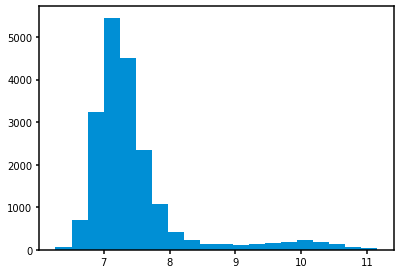

In [1198]:
transiting_planets = [1]

## obtain a/R given the stellar density (rho)
if 'rho' in results.posteriors['posterior_samples'].keys() or 'rho' in dataset.priors.keys():
    try:
        rho = results.posteriors['posterior_samples']['rho']
    except KeyError: # rho was a fixed parameter then
        rho = dataset.priors['rho']['hyperparameters']
        # if dataset.priors['rho']['distribution'] == 'fixed':
        #     rho = dataset.priors['rho']['hyperparameters']
        # elif dataset.priors['rho']['distribution'] == 'normal':
        #     rho = np.random.normal(loc=dataset.priors['rho']['hyperparameters'][0], scale=dataset.priors['rho']['hyperparameters'][1],size=num_samps)
        # else:
        #     rho = dataset.priors['rho']['hyperparameters'][0]
    for i_transit in transiting_planets:
        try:
            P = results.posteriors['posterior_samples']['P_p{}'.format(i_transit)]
        except KeyError:
            P = dataset.priors['P_p{}'.format(i_transit)]['hyperparameters']

        a = ((rho*G*((P*24.*3600.)**2))/(3.*np.pi))**(1./3.)
        results.posteriors['posterior_samples']['a_p{}'.format(i_transit)] = a

results.posteriors['posterior_samples']['transittime_p{}'.format(i_transit)] = get_transittime(period=P, aR=results.posteriors['posterior_samples']['a_p{}'.format(i_transit)],\
                                                                                                    p=results.posteriors['posterior_samples']['p_p{}'.format(i_transit)],\
                                                                                                    b=results.posteriors['posterior_samples']['b_p{}'.format(i_transit)])

plt.hist(results.posteriors['posterior_samples']['transittime_p1'])
np.median(results.posteriors['posterior_samples']['transittime_p1'])

# Demographics

use TEPCat catalog of well-characterized planets (https://www.astro.keele.ac.uk/jkt/tepcat/html-catalogue.html)

In [15]:
TEPCat =  pd.read_csv('/Users/schlecker/repos/notebooks/data/TEPcat_allplanets.csv')
TEPCat.columns = [c.strip() for c in TEPCat.columns]

# unfortunately, there are duplicate column names in the TEPCat catalog. What follows is an ugly hack to overcome that.
cols=pd.Series(TEPCat.columns)
for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
# rename the columns with the cols list.
TEPCat.columns=cols
TEPCat.columns

Index(['System', 'Teff', 'err', 'err .1', '[Fe/H]', 'erru', 'errd', 'M_A',
       'errup', 'errdn', 'R_A', 'errup .1', 'errdn .1', 'loggA', 'errup .2',
       'errdn .2', 'rho_A', 'errup1', 'errdn1', 'Period', 'e', 'errup2',
       'errdown', 'a(AU)', 'errup3', 'errdown1', 'M_b', 'errup4', 'errdn2',
       'R_b', 'errup .11', 'errdn .11', 'g_b', 'errup .21', 'errdn .21',
       'rho_b', 'errup .3', 'errdn .3', 'Teq', 'err .2', 'err .3',
       'Discovery_reference', 'Recent_reference'],
      dtype='object')

In [16]:
TEPCat['errup2'].describe()

count    949.000000
mean      -0.331673
std        0.555968
min       -1.000000
25%       -1.000000
50%        0.009800
75%        0.090000
max        0.790000
Name: errup2, dtype: float64

In [17]:
# need to execute get_planetaryparams() first (see above)!

P, P_err_up, P_err_lo = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['P_p1'])
e, e_err_up, e_err_lo = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['ecc_p1'])
M, M_err_up, M_err_lo = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['mass_mj_p1'])

fig, ax = plots.plot_periodEcc(TEPCat, P=P, e=e, P_err=[P_err_up, P_err_lo], e_err=[e_err_up, e_err_lo], M=M, color=None)#color='Teff')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


showing 460 planets.


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


In [18]:
# fig.savefig('/Users/schlecker/WINE/TIC237913194/out/39_tess+chat+feros+GP/' + 'periodEcc.pdf')

which ecc percentile is our planet in?

In [40]:
tep = TEPCat.copy()
# same filtering as in the plot
tep = c[~((tep.e ==0) & (tep.errup2 > 0) | (tep.e < 0))] 
# tep = c[tep.Teff.between(5200,6000)]
tep = c[tep.M_b > 0]
tep.e.quantile(.98, interpolation='nearest')

0.57

# Fancy Orbit visualization
adapted from the starry tutorials (Luger et al. 2019)
**TO DO: adapt orbit parameters to our system**

In [184]:
# %run notebook_setup.py

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
starry.config.lazy = False
starry.config.quiet = True

In [ ]:
rv = True
A = starry.Primary(starry.Map(udeg=2, amp=1.0, rv=rv), r=1.0, m=1.0)
A.map[1:] = [0.5, 0.25]

for Omega in [0]:#np.linspace(0, 90, 3):
    b = starry.Secondary(
        starry.Map(ydeg=1, inc=80.0, obl=30.0, amp=0.1, rv=rv),
        r=0.5,
        m=0.5,
        porb=1.,
        prot=1.0,
        t0=0.,
        inc=80.0,
        omega = 0.,
        ecc = .57,
        Omega=Omega,
    )
    b.map.load("earth")

    sys = starry.System(A, b)

    npts = 200
    t = np.linspace(-0.5, 0.5, npts)
    x, y, z = sys.position(t)

    res = 200
    theta_sec = [360.0 / sec.prot * (t - sec.t0) - sec.theta0 for sec in sys.secondaries]
    img = np.array(
        [np.tile(sys.primary.map.render(res=res), (npts, 1, 1))]
        + [
            sec.map.render(theta=theta_sec[i], res=res)
            for i, sec in enumerate(sys.secondaries)
        ]
    )

    flux = sys.flux(t)
    sys.show(t, interval=30, figsize=(2, 2))

In [ ]:
for Omega in np.linspace(0, 90*np.pi/180, 3):
    b._Omega = Omega
    sys = starry.System(A, b)

    npts = 100
    t = np.linspace(-0.5, 0.5, npts)
    x, y, z = sys.position(t)

    res = 50
    theta_sec = [360.0 / sec.prot * (t - sec.t0) - sec.theta0 for sec in sys.secondaries]
    img = np.array(
        [np.tile(sys.primary.map.render(res=res), (npts, 1, 1))]
        + [
            sec.map.render(theta=theta_sec[i], res=res)
            for i, sec in enumerate(sys.secondaries)
        ]
    )

    flux = sys.flux(t)
    
    
    # Set up the plot
    fig, ax = plt.subplots(1, figsize=(3, 3))
#     ax_xz = fig.add_axes([0.275, 0.8, 0.2, 0.2])
#     ax_xz.annotate(
#         "Top", fontsize=12, xy=(0, 0), xycoords="axes fraction", ha="left", va="bottom"
#     )
#     ax_zy = fig.add_axes([0.525, 0.8, 0.2, 0.2])
#     ax_zy.annotate(
#         "Side", fontsize=12, xy=(0, 0), xycoords="axes fraction", ha="left", va="bottom"
#     )
    ax_lc = fig.add_axes([0.125, 0.05, 0.775, 0.2])

    xz = [None] + [None for sec in sys.secondaries]
    xy = [None] + [None for sec in sys.secondaries]
    zy = [None] + [None for sec in sys.secondaries]
    circ = [None] + [None for sec in sys.secondaries]
    maps = [sys.primary.map] + [sec.map for sec in sys.secondaries]
    radii = np.array([sys.primary.r] + [sec.r for sec in sys.secondaries])

#     for axis, arrs in zip([ax, ax_xz, ax_zy], [(x, y), (x, z), (z, y)]):
    for axis, arrs in zip([ax], [(x, y)]):
        axis.axis("off")
        R = 1.2 * max(-np.min(arrs), np.max(arrs))
        axis.set_xlim(-R, R)
        axis.set_ylim(-R, R)

    # # Plot the light curve
    # ax_lc.plot(t, flux, "k-")
    # (lc,) = ax_lc.plot(t[0], flux[0], "o", color="k")
    # ax_lc.axis("off")

    # plot rv
    rv = sys.rv(t)
    ax_lc.plot(t, rv, "k-")
    (lc,) = ax_lc.plot(t[0], rv[0], "o", color="k")
    ax_lc.axis("off")

    # Plot the first frame
    for i, xi, yi, zi, map, r in zip(range(1 + len(sys.secondaries)), x, y, z, maps, radii):

#         # Orbit outlines
#         ax_xz.plot(xi, zi)
#         ax_zy.plot(zi, yi)

#         # Body positions
#         xz[i] = ax_xz.scatter(xi[0], zi[0])
#         zy[i] = ax_zy.scatter(zi[0], yi[0])

        # Maps
        extent = np.array([xi[0], xi[0], yi[0], yi[0]]) + np.array([-1, 1, -1, 1]) * r
        xy[i] = ax.imshow(
            img[i, 0],
            origin="lower",
            cmap="plasma",
            extent=extent,
            clip_on=False,
            zorder=zi[0],
        )
        circ[i] = plt.Circle(
            (xi[0], yi[0]), r, color="k", fill=False, zorder=zi[0] + 1e-3, lw=3
        )
        ax.add_artist(circ[i])

    # Animation
    def updatefig(k):
        for i, xi, yi, zi, map, r in zip(
            range(1 + len(sys.secondaries)), x, y, z, maps, radii
        ):
#             xz[i].set_offsets((xi[k], zi[k]))
#             zy[i].set_offsets((zi[k], yi[k]))
            xy[i].set_extent(
                np.array([xi[k], xi[k], yi[k], yi[k]]) + np.array([-1, 1, -1, 1]) * r
            )
            xy[i].set_zorder(zi[k])
            xy[i].set_data(img[i, k])
            circ[i].center = (xi[k], yi[k])
            circ[i].set_zorder(zi[k] + 1e-3)
        lc.set_xdata(t[k])
        lc.set_ydata(flux[k])
#         return xz + xy + zy + circ + [lc]
        return xy + circ + [lc]


    ani = FuncAnimation(fig, updatefig, interval=30, blit=False, frames=len(t))
    plt.close()
    display(HTML(ani.to_html5_video()))